In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import astropy.constants as c
import astropy.units as u
import sys
sys.path.pop(1)
sys.path.insert(0,'../')

In [3]:
import pyathena as pa

In [130]:
units=pa.set_units(muH=1.4271)
Myr=units['time'].to('Myr').value
surf_unit=(units['density']*units['length']).to('Msun/pc^2').value

In [161]:
base='/Users/cgkim/Dropbox/ongoing_work/chiral_structure/'
id='MHD_8pc_S_q01'

In [162]:
h=pa.hst_reader('%s%s.hst' % (base,id))
sn=pa.hst_reader('%s%s.sn' % (base,id))
par,block,field=pa.parse_par('%s%s.0000.rst' % (base,id))

Reading a history file:/Users/cgkim/Dropbox/ongoing_work/chiral_structure/MHD_8pc_S_q01.hst.p
Reading a history file:/Users/cgkim/Dropbox/ongoing_work/chiral_structure/MHD_8pc_S_q01.sn.p


In [163]:
Lz=eval(par['domain1']['x3max'][0])-eval(par['domain1']['x3min'][0])
Lz

3584

In [164]:
tmin=200
tmax=np.min([int(h.time.max()),500])
print tmax,tmin,tmax-tmin

snrate,tsn=np.histogram(sn.time,bins=tmax-tmin,range=(tmin,tmax))
snrate=snrate/Myr/1024.**2
tsn=tsn[:-1]

481 200 281


In [165]:
sfr10=np.interp(tsn,h.time,h.sfr10)
sfr40=np.interp(tsn,h.time,h.sfr40)
sfr100=np.interp(tsn,h.time,h.sfr100)
surf=np.interp(tsn,h.time,h.mass*Lz*surf_unit)

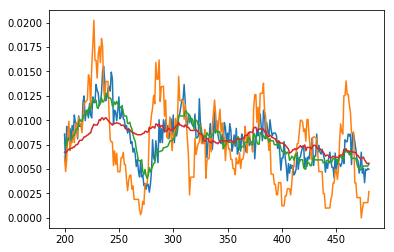

In [166]:
plt.plot(tsn,snrate*100)
plt.plot(tsn,sfr10)
plt.plot(tsn,sfr40)
plt.plot(tsn,sfr100)

In [167]:
vx=np.interp(tsn,h.time,np.sqrt(0.5*h.x1KE_2p/h.mass))
vy=np.interp(tsn,h.time,np.sqrt(0.5*h.x2KE_2p/h.mass))
vz=np.interp(tsn,h.time,np.sqrt(0.5*h.x3KE_2p/h.mass))
vt=np.sqrt(vx**2+vy**2+vz**2)
Hc=np.interp(tsn,h.time,np.sqrt((h.H2c+h.H2u)/h.mass))
Hw=np.interp(tsn,h.time,np.sqrt((h.H2w)/h.mass))

In [168]:
Omega=28.
Q=(vx*np.sqrt(2)*Omega*u.km/u.s/u.kpc*u.km/u.s/np.pi/c.G/(surf*c.M_sun/c.pc**2)).cgs.value

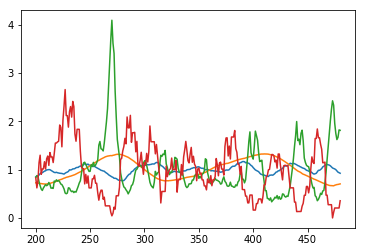

In [169]:

plt.plot(tsn,vt/vt.mean())
plt.plot(tsn,Hw/Hw.mean())
plt.plot(tsn,Hc/Hc.mean())
plt.plot(tsn,sfr10/sfr10.mean())

In [170]:
import cPickle as p
p.dump({'time':tsn,'snrate':snrate,'sfr10':sfr10,'sfr40':sfr40,'sfr100':sfr100,'vt':vt,'Hc':Hc,'Hw':Hw},
       open('%s%s.history.p' % (base,id),'wb'),p.HIGHEST_PROTOCOL)